# Self-Driving Car Engineer Nanodegree

## Vehicle Detection

In this notebook, we will create a pipeline to identify vehicles on a video. To do so, we will need to go over the following steps:
* Extract the features of an image that allow us to classify it as a car (or not a car).
* Train a Classifier that will use the above features to correctly identify images as cars (or not cars).
* Develop a way to canvass the a frame of the video to look for likely vehicles.
* Combine all the above to accurately detect cars in the video.


## Step 1: Extracting features

We begin by implementing the HOG extraction. We will use a few images from our training Data set.

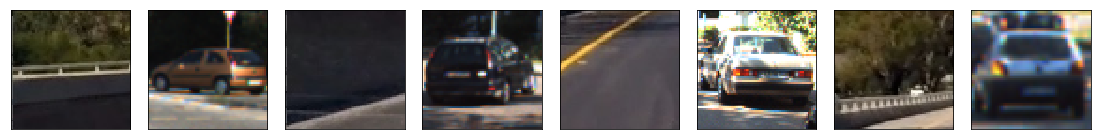

In [1]:
import numpy as np
import cv2
import glob

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import os
%matplotlib inline

# Make a list of calibration images
hog_dir = 'HOGTest'
image_names = [os.path.join(hog_dir, x) for x in os.listdir(hog_dir)]
# Step through the list and search for chessboard corners
images = []
for fname in image_names:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img) 

fig = plt.figure(figsize = (15, 15))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)
for i in range(len(images)):
    axis = fig.add_subplot(1, len(images), i + 1, xticks=[], yticks=[])
    axis.imshow(images[i])
plt.show()

Above we see eight examples of the images we will use for training. Next, we show how the images look after we apply HOG.

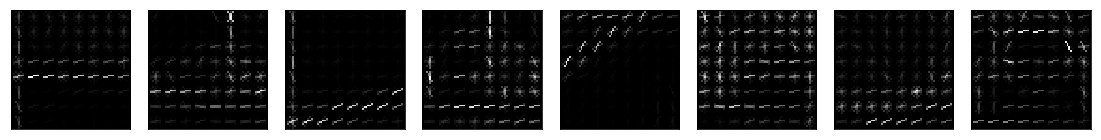

In [2]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

fig = plt.figure(figsize = (15, 15))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)
for i in range(len(images)):
    img = images[i]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    axis = fig.add_subplot(1, len(images), i + 1, xticks=[], yticks=[])
    axis.imshow(hog_image, cmap='gray')

    
plt.show()


Below is our pipeline for the feature extraction.

In [3]:
#
# We need to define some parameters in order to use the Open CV Hog functionality for our project.
# While researching HOG, we encountered the recommendation to use cv2 instead of scikit and found it to be faster.
#

def init_hog(img_shape, orient=9, pix_per_cell=8, cell_per_block=2):
    
    cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
    block_size = (cell_per_block, cell_per_block)  # h x w in cells
    nbins = orient  # number of orientation bins

    # winSize is the size of the image cropped to an multiple of the cell size
    hog_params = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                      img_shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    return hog_params


def extract_features(imgs, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # 
    hog_params = None
    features = []
    for fname in imgs:
        
        img = cv2.imread(fname)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
        if hog_params is None:
            hog_params = init_hog(img.shape, orient, pix_per_cell, cell_per_block)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(hog_params.compute(feature_image[:,:,channel])[:,0])   
            hog_features=np.asarray(hog_features).ravel()
        else:
            hog_features = hog_params.compute(feature_image[:,:,hog_channel])[:,0]
       
        features.append(np.asarray(hog_features))

    return features



In [4]:
features = extract_features(image_names, color_space='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
print(features[0].shape)

(5292,)


We have the training data provided by Udacity. Part of it is from a time series, which means many of the images are very similar. All of the time series data will be used as part of the training set, with the validation set coming exclusively from KITTI.

In [5]:
import time

cars_KITTI = glob.iglob('Training/vehicles/KITTI/*.png')
cars_GTI = glob.iglob('Training/vehicles/GTI/*.png')
non_cars_KITTI = glob.iglob('Training/non-vehicles/KITTI/*.png')
non_cars_GTI = glob.iglob('Training/non-vehicles/GTI/*.png')

t=time.time()

features_cars_KITTI = extract_features(cars_KITTI, color_space='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
features_cars_GTI = extract_features(cars_GTI, color_space='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
features_non_cars_KITTI = extract_features(non_cars_KITTI, color_space='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
features_non_cars_GTI = extract_features(non_cars_GTI, color_space='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

print('Number of images of cars (KITTI) ', len(features_cars_KITTI))
print('Number of images of cars (GTI) ', len(features_cars_GTI))
print('Number of images of non cars (KITTI) ', len(features_non_cars_KITTI))
print('Number of images of non cars (GTI) ', len(features_non_cars_GTI))

12.01 Seconds to extract features...
Number of images of cars (KITTI)  5959
Number of images of cars (GTI)  2826
Number of images of non cars (KITTI)  5064
Number of images of non cars (GTI)  3900


In [6]:
# We want to extract the test set exclusively from the KITTI examples, so we take 30 % of them.
# and then we add the 

X_K = np.vstack((features_cars_KITTI, features_non_cars_KITTI)).astype(np.float64)                        
y_K = np.hstack((np.ones(len(features_cars_KITTI)), np.zeros(len(features_non_cars_KITTI))))
X_train, X_test, y_train, y_test = train_test_split(X_K, y_K, test_size=0.3)

X_train = np.vstack((X_train, features_cars_GTI, features_non_cars_GTI)).astype(np.float64)  
y_train = np.hstack((y_train, np.ones(len(features_cars_GTI)), np.zeros(len(features_non_cars_GTI))))

X_train, y_train = shuffle(X_train, y_train)

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)


In [7]:
# fit a classifier
svc = LinearSVC()
svc.fit(X_train, y_train)
X_test = X_scaler.transform(X_test)
print('Test Accuracy of Classifier = ', round(svc.score(X_test, y_test), 4))


Test Accuracy of SVC =  0.9949
